```{note}
If running in Colab, think of changing the runtime type before starting, in
order  to have access to GPU ressources: Runtime->Change Runtime Type, then
chose GPU for hardware accelerator.
```


In this lab we will focus on **image synthesis**, in particular to
synthesize **T2-weighted MRI** from **T1-weighted MRI**.

We will investigate three approaches to do so:

1. First, we will train a generator (or encoder-decoder).
2. Then, we will train a conditional generative adversarial network (cGAN).
3. Finally, we will train a cycle generative adversarial network (CycleGAN).

We will evaluate the quality of the generated images using several metrics.

We will use the [IXI dataset](https://brain-development.org/ixi-dataset/)
to have access to **paired T1-w and T2-w images**.
Before creating and training the different neural networks,
we will:

1. fetch the dataset,
2. have a look at it to see what the task looks like, and
3. illustrate how to easily access the data.

# 0. Fetching the dataset

The dataset can be found on this
[server](https://aramislab.paris.inria.fr/files/data/databases/DL4MI/IXI-dataset.tar.gz)
and alternatively in the following
[GitHub repository](https://github.com/Easternwen/IXI-dataset).
In the `size64` folder, there are 1154 files: 2 images for 577 subjects.
The size of each image is (64, 64).

Let's download the file and have a look at the data.

In [17]:
# Get the dataset from the server
! git clone https://github.com/Easternwen/IXI-dataset.git

fatal: destination path 'IXI-dataset' already exists and is not an empty directory.


The dataset used in this lab is composed of preprocessed images from the
[IXI dataset](https://brain-development.org/ixi-dataset/). Two different
structural MRI modalities are comprised in this dataset:

- T1 weighted images

- T2 weighted images

These modalities do not highlight the same tissues: for example the CSF
voxels are cancelled in T1 weighted imaging whereas they are highlighted by
the T2 weighted imaging.

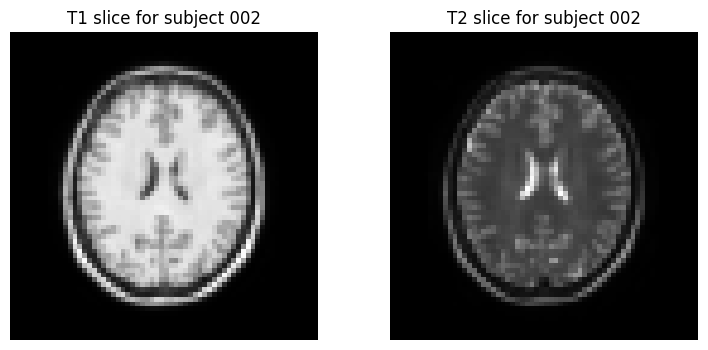

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch


root = "./IXI-dataset/size64/"

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T1.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T1 slice for subject 002")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T2.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T2 slice for subject 002")
plt.axis('off')
plt.show()

Let's import all the necessary packages.

In [54]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time

import torch.optim as optim

Let's create a custom `IXIDataset` class to easily have access to the data.
Here we don't use tsv files to split subjects between the training and the
test set. We only set the dataset to the `train` or `test` mode to access
training or test data.

In [20]:
class IXIDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Args:
        root: (str) Path of the folder with all the images.
        mode : {'train' or 'test'} Part of the dataset that is loaded.

    """
    def __init__(self, root, mode="train"):

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[:int(0.8 * len(patient_id))]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        elif mode == "test":
            for i in patient_id[int(0.8 * len(patient_id)):]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        self.imgs = imgs

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]

        t1 = torch.load(t1_path)[None, :, :]
        t2 = torch.load(t2_path)[None, :, :]

        return {"T1": t1, "T2": t2}

    def __len__(self):
        return len(self.imgs)

Using this class and the `DataLoader` class from `torch.utils.data`, you can
easily have access to your dataset. Here is a quick example on how to use it:

```python
# Create a DataLoader instance for the training set
# You will get a batch of samples from the training set
dataloader = DataLoader(
    IXIDataset(root, mode="train"),
    batch_size=1,
    shuffle=False,
)

for batch in dataloader:
    # batch is a dictionary with two keys:
    # - batch["T1"] is a tensor with shape (batch_size, 64, 64) with the T1 images for the samples in this batch
    # - batch["T2"] is a tensor with shape (batch_size, 64, 64) with the T2 images for the samples in this batch
```

# 1. Generator

## 1.1 Architecture

The generator will have a **U-Net architecture** with the following
characteristics:

* the descending blocks are convolutional layers followed by instance
  normalization with a LeakyReLU activation function;

* the ascending blocks are transposed convolutional layers followed by
  instance normalization with a ReLU activation function.

The parameters for each layer are given in the picture below.

<a href="https://ibb.co/QXBDNy3">
    <img src="https://i.ibb.co/g614TkL/Capture-d-cran-2020-03-02-16-04-06.png" width="800" border="0">
</a>


<div class="alert alert-block alert-info">
<b>Exercise</b>: Create a <code>GeneratorUNet</code> class to define the
generator with the architecture given above.
</div>

In [21]:
# We provide classes for each block of the U-Net.

class UNetDown(nn.Module):
    """Descending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.LeakyReLU(0.2)
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    """Ascending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x

In [23]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()
        # U-Net layers according to provided image
        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        self.final = FinalLayer(128, out_channels)

    def forward(self, x):
        # U-Net forward pass logic
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5)
        u2 = self.up2(u1, d4)
        u3 = self.up3(u2, d3)
        u4 = self.up4(u3, d2)

        out = self.final(u4, d1)

        return out

Let's have a look at the architecture of our generator:

In [24]:
# Summary of the generator
summary(GeneratorUNet().cuda(), (1, 64, 64) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
    InstanceNorm2d-2           [-1, 64, 32, 32]               0
         LeakyReLU-3           [-1, 64, 32, 32]               0
          UNetDown-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-6          [-1, 128, 16, 16]               0
         LeakyReLU-7          [-1, 128, 16, 16]               0
          UNetDown-8          [-1, 128, 16, 16]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
   InstanceNorm2d-10            [-1, 256, 8, 8]               0
        LeakyReLU-11            [-1, 256, 8, 8]               0
         UNetDown-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
   InstanceNorm2d-14            [-1, 51

## 1.2 Train the generator

In order to train the generator, we will repeat the following process:

1. Generate T2-w images from T1-w images.
2. Compute the error between the true T2-w images and the generated T2-w images.
3. Update the parameters of the generators.

The training phase looks like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator

        # Perform one optimization step
```

<div class="alert alert-block alert-info">
<b>Exercise</b>: We provide below a template to train our generator
 on the dataset. Fill in the missing parts.
</div>

In [26]:
def train_generator(train_loader, test_loader, num_epoch=500,
                    lr=0.0001, beta1=0.9, beta2=0.999):
    """Train a generator on its own.

    Args:
        train_loader: (DataLoader) a DataLoader wrapping the training dataset
        test_loader: (DataLoader) a DataLoader wrapping the test dataset
        num_epoch: (int) number of epochs performed during training
        lr: (float) learning rate of the discriminator and generator Adam optimizers
        beta1: (float) beta1 coefficient of the discriminator and generator Adam optimizers
        beta2: (float) beta1 coefficient of the discriminator and generator Adam optimizers

    Returns:
        generator: (nn.Module) the trained generator
    """

    cuda = True if torch.cuda.is_available() else False
    print(f"Using cuda device: {cuda}")  # check if GPU is used

    # Tensor type (put everything on GPU if possible)
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    # Output folder
    if not os.path.exists("./images/generator"):
        os.makedirs("./images/generator")

    # Loss function
    criterion = nn.L1Loss() # This line was missing, initializing criterion with L1Loss as suggested in the comment

    # Initialize the generator
    generator = GeneratorUNet() # This line was missing, initializing the generator

    if cuda:
        generator = generator.cuda()
        criterion.cuda()

    # Optimizer
    optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        """Saves a generated sample from the validation set"""
        imgs = next(iter(test_loader))
        real_A = imgs["T1"].type(Tensor)
        real_B = imgs["T2"].type(Tensor)
        fake_B = generator(real_A)
        img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
        save_image(img_sample, f"./images/generator/epoch-{epoch}.png",
                   nrow=5, normalize=True)

    # ----------
    #  Training
    # ----------

    prev_time = time.time()

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)

            # Remove stored gradients
            optimizer.zero_grad()

            # Generate fake T2 images from the true T1 images
            fake_t2 = generator(real_t1) # This line was missing, generating the fake T2 images

            # Compute the corresponding loss
            loss = criterion(fake_t2, real_t2) # This line was missing, computing the loss

            # Compute the gradient and perform one optimization step
            loss.backward()
            optimizer.step()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_loader) + i
            batches_left = num_epoch * len(train_loader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f] ETA: %s"
                % (
                    epoch + 1,
                    num_epoch,
                    i,
                    len(train_loader),
                    loss.item(),
                    time_left,
                )
            )

        # Save images at the end of each epoch
        sample_images(epoch)

    return generator

In [27]:
# Parameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create dataloaders
batch_size = 40
train_loader = DataLoader(IXIDataset(root, mode="train"),
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(IXIDataset(root, mode="test"),
                         batch_size=5,
                         shuffle=False)

# Number of epochs
num_epoch = 20

# Train the generator
generator = train_generator(train_loader, test_loader, num_epoch=num_epoch,
                            lr=lr, beta1=beta1, beta2=beta2)

Using cuda device: True
[Epoch 20/20] [Batch 11/12] [Loss: 0.036909] ETA: 0:00:00.057956

## 1.3 Evaluate the generator

Let's visualize a few generated T2-weighted images:

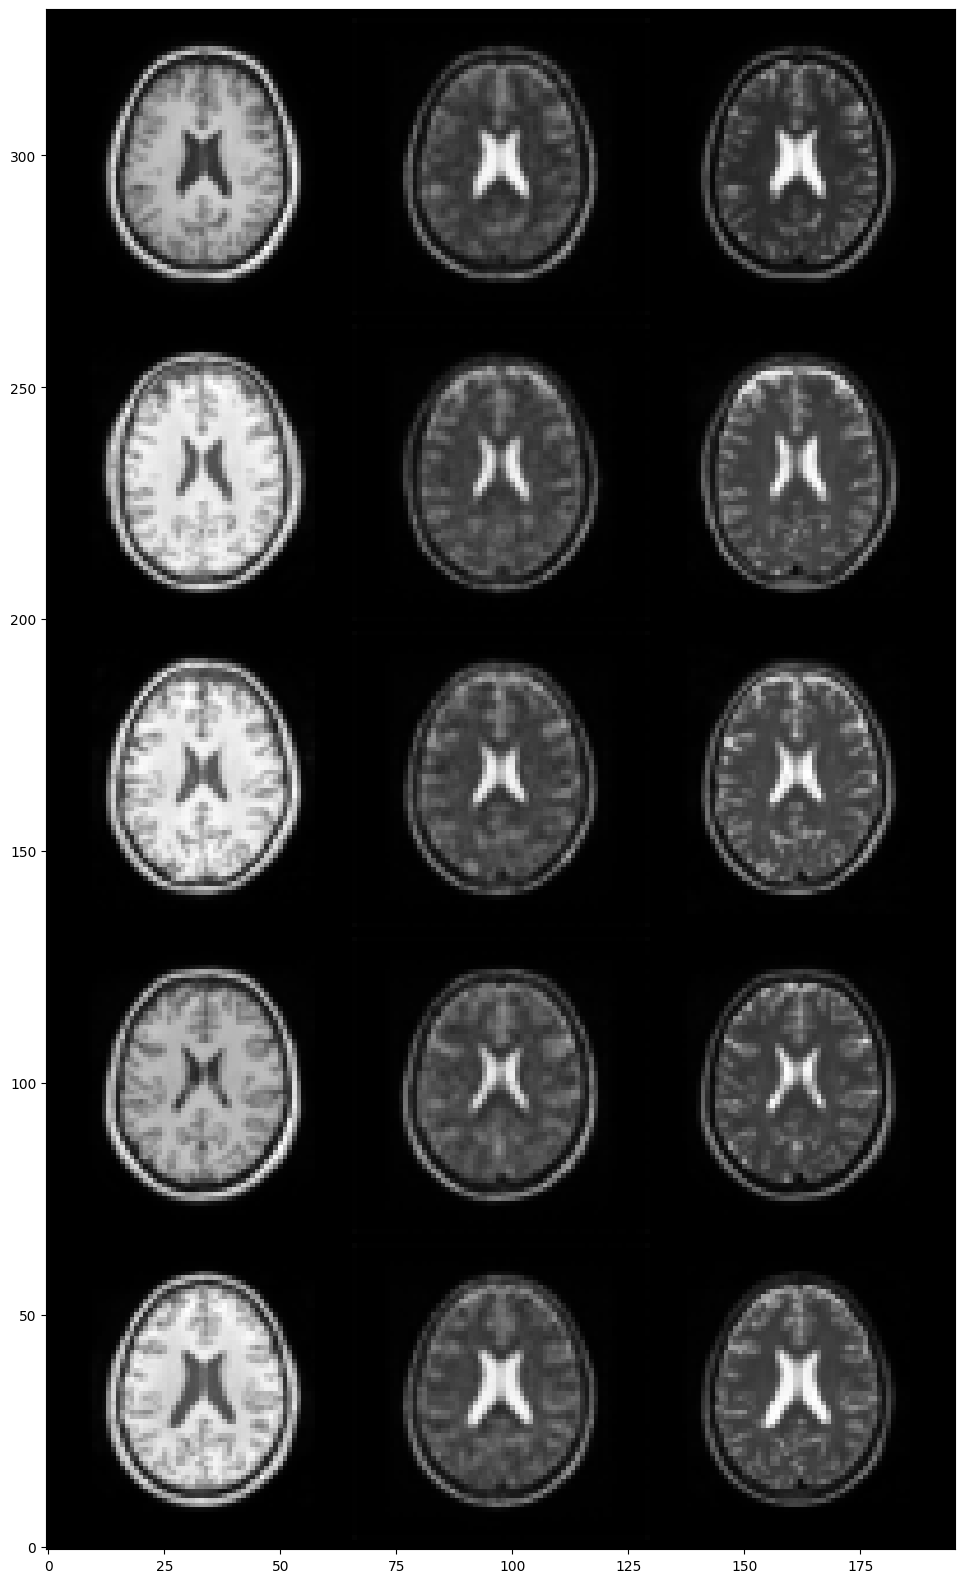

In [28]:
im = img.imread(f'./images/generator/epoch-{num_epoch - 1}.png')
plt.figure(figsize=(20, 20))
plt.imshow(np.swapaxes(im, 0, 1))
plt.gca().invert_yaxis()
plt.show()

After doing visual quality control, it is a good idea to quantify the quality
of the generated images using specific metrics. Some popular metrics include
the Mean Absolute Error (MAE), the Peak Signal-to-Noise Ratio (PSNR) and
the Structural Similarity index (SSIM):

* MAE = $\displaystyle \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m \vert T_{ij} - G_{ij} \vert $

* PSNR = $\displaystyle -10 \log_{10} \left( \frac{1}{nm} \sum_{i=1}^n \sum_{j=1}^m (T_{ij} - G_{ij})^2 \right) $

* SSIM = $\displaystyle  \frac{(2 \mu_T \mu_G + C_1)(2 \sigma_{TG} + C_2)}{(\mu_T^2 +
\mu_G^2 + C_1)(\sigma_T^2 + \sigma_G^2 + C_2)} $ where:

    * $\mu$ and $\sigma$ are the mean value and standard deviation of an image respectively, and
    * $C_1$ and $C_2$ are two positive constants (one can take $C_1=0.01$ and $C_2=0.03$).

The [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
is simply the mean of each absolute value of the difference between
the true pixel ($T_{ij}$) and the generated pixel ($G_{ij}$).
The lower, the better. Minimum value is 0.

The [peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
is a function of the mean squared error and allows for comparing
images encoded with different scales. We simplified its formula in our case.
The higher, the better. Maximum value is $+\infty$.

The [structural similarity index](https://en.wikipedia.org/wiki/Structural_similarity)
is a weighted combination of the luminance, the contrast and the structure.
The higher, the better. Maximum value is 1.

For those interested, you can find [here](https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/)
a reference to better understand the differences between these metrics.

We provide an implementation for each metric with the functions below.

In [29]:
def mean_absolute_error(image_true, image_generated):
    """Compute mean absolute error.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        mse: (float) mean squared error
    """
    return torch.abs(image_true - image_generated).mean()


def peak_signal_to_noise_ratio(image_true, image_generated):
    """"Compute peak signal-to-noise ratio.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image

    Returns:
        psnr: (float) peak signal-to-noise ratio"""
    mse = ((image_true - image_generated) ** 2).mean().cpu()
    return -10 * np.log10(mse)


def structural_similarity_index(image_true, image_generated, C1=0.01, C2=0.03):
    """Compute structural similarity index.

    Args:
        image_true: (Tensor) true image
        image_generated: (Tensor) generated image
        C1: (float) variable to stabilize the denominator
        C2: (float) variable to stabilize the denominator

    Returns:
        ssim: (float) mean squared error"""
    mean_true = image_true.mean()
    mean_generated = image_generated.mean()
    std_true = image_true.std()
    std_generated = image_generated.std()
    covariance = (
        (image_true - mean_true) * (image_generated - mean_generated)).mean()

    numerator = (2 * mean_true * mean_generated + C1) * (2 * covariance + C2)
    denominator = ((mean_true ** 2 + mean_generated ** 2 + C1) *
                   (std_true ** 2 + std_generated ** 2 + C2))
    return numerator / denominator

We will now evaluate the generator with these three metrics on both the
training set and the test set by computing the mean value for each metric.

In [30]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(test_loader):

            # Inputs T1-w and T2-w
            real_t1 = batch["T1"].type(Tensor)
            real_t2 = batch["T2"].type(Tensor)
            fake_t2 = generator(real_t1)

            mae = mean_absolute_error(real_t2, fake_t2).item()
            psnr = peak_signal_to_noise_ratio(real_t2, fake_t2).item()
            ssim = structural_similarity_index(real_t2, fake_t2).item()

            res_test.append([mae, psnr, ssim])

    df = pd.DataFrame([
        pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
        pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
    ], index=['Training set', 'Test set']).T
    return df

In [31]:
evaluate_generator(generator)

<ipython-input-29-f4002985bd60>:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -10 * np.log10(mse)


,Training set,Test set
MAE,0.036686,0.044972
PSNR,22.371286,20.753071
SSIM,0.980497,0.970757


The performance is already really good! The task may be pretty easy.
Let's see if we can still improve the performance with a more complex neural
network.

# 2. Conditional Generative Adversarial Network (cGAN)

A generative adversarial network (GAN) is a network generating new samples.
A typical GAN consists of two networks:

* a **generator** that generates new samples, and
* a **discriminator** that discriminate generated samples from true samples.

One can think of the generator as a *counterfeiter* and the discriminator
as a *authenticator*.
The discriminator aims at improving the generator by having an opposition.
The discriminator must not be too good, otherwise the generator won't improve.
The generator and the discriminator are trained simultaneously and help
each other improve.

A conditional generative adversarial network (cGAN) is a particular case
of a GAN that is conditioned by the true sample.
A conditional GAN can thus only be used when **paired samples** are available.

## 2.1 Architecture of the cGAN

Like a GAN, a cGAN has two networks:

* a **generator** that generates new samples, and

* a **discriminator** that discriminate generated samples from true samples.

We will keep the same architecture for the generator.

For the discriminator we will use a **two-dimensional convolutional neural
network** with 5 layers:

* the first 4 layers are 2D-convolutional layers with  a LeakyReLU activation
function;

* the last layer is a 2D-convolutional layer.

The parameters for each layer are given in the figure below. Don't forget
that the input of the discriminator will be the generated image and the true
image since we are using a conditional GAN. Therefore, the number of input
channels for the first layer will be two (one for each image).

<a href="https://ibb.co/9b2jF0V">
  <img src="https://i.ibb.co/hBHvPNZ/Capture-d-cran-2020-03-02-16-04-14.png" width="800"  border="0">
</a>

<div class="alert alert-block alert-info">
 <b>Exercise</b>: Create a <code>Discriminator</code> class to define the
 discriminator with the architecture given above.
</div>

In [33]:
# We provide a function to generate a block for the given architecture.
def discriminator_block(in_filters, out_filters):
    """Return downsampling layers of each discriminator block"""
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        # Discriminator layers according to provided image
        layers = []
        layers.extend(discriminator_block(in_channels * 2, 64))
        layers.extend(discriminator_block(64, 128))
        layers.extend(discriminator_block(128, 256))
        layers.extend(discriminator_block(256, 512))

        # Final layer without LeakyReLU
        layers.append(nn.Conv2d(512, 1, 3, padding=1))

        self.model = nn.Sequential(*layers)


    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

Let's have a look at the architecture of our discriminator:

In [34]:
# Summary of the discriminator
summary(Discriminator().cuda(), [(1, 64, 64), (1, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,216
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         295,168
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 4, 4]           4,609
Total params: 1,555,009
Trainable params: 1,555,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 64.00
Forward/backward pass size (MB): 1.88
Params size (MB): 5.93
Estimated Total Size (MB): 71.81
-------------------------------------

## 2.2 Training our conditional GAN

Now that we have created our generator and our discriminator, we have to
train them on the dataset.

**Notations**

* $X_{T1}$: true T1 image;
* $X_{T2}$: true T2 image;
* $\tilde{X}_{T2}$: generated T2 image from $X_{T1}$;
* $\hat{y}_{X}$: probability returned by the discriminator that the ${X}_{T2}$ is real;
* $\hat{y}_{\tilde{X}}$: probability returned by the discriminator that the $\tilde{X}_{T2}$ is real.

**Training the generator**

The loss for the generator is the sum of:

* the binary cross-entropy loss between the predicted probabilities of the
generated images and positive labels,
* the pixel-wise mean absolute error between the generated image and the true
image.

For one sample, it is then:

$$
\ell_G = - \log(\hat{y}_{\tilde{X}}) + \lambda * \text{MAE}(X_{T2}, \tilde{X}_{T2})
$$

**Training the discriminator**

The loss for the generator is the mean of:

* the binary cross-entropy loss between the predicted probabilities of the
generated images and negative labels,
* the binary cross-entropy loss between the predicted probabilities
of the true images and positive labels.

For one sample, it is then:

$$
\ell_D = - 0.5 * \log(\hat{y}_{X}) - 0.5 * \log(1 - \hat{y}_{\tilde{X}})
$$

**Training phase**

The generator and the discriminator are trained simultaneously, which makes
the training phase look like this:

```
# For each epoch

    # For each batch

        # Generate fake images for all the images in this batch

        # Compute the loss for the generator and perform one optimization step

        # Compute the loss for the discriminator and perform one optimization step
```

<div class="alert alert-block alert-info">
<b>Exercise</b>: We provide below a template to train our conditional GAN
 on the dataset. Fill in the missing parts.
</div>

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image

# -----------------------------
#        Generator (U-Net)
# -----------------------------
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        def conv_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=1, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.encoder = nn.Sequential(
            *conv_block(in_channels, 64, normalize=False),
            *conv_block(64, 128),
            *conv_block(128, 256)
        )

        self.decoder = nn.Sequential(
            *conv_block(256, 128),
            *conv_block(128, 64),
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# -----------------------------
#      Discriminator (PatchGAN)
# -----------------------------
def discriminator_block(in_filters, out_filters):
    layers = [nn.Conv2d(in_filters, out_filters, 3, stride=2, padding=1)]
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        layers = []
        layers.extend(discriminator_block(in_channels * 2, 64))
        layers.extend(discriminator_block(64, 128))
        layers.extend(discriminator_block(128, 256))
        layers.extend(discriminator_block(256, 512))
        layers.append(nn.Conv2d(512, 1, 3, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)  # Concatenate input images
        return self.model(img_input)

# -----------------------------
#       Training Function
# -----------------------------
def train_cgan(train_loader, test_loader, num_epoch=100, lr=0.0002, beta1=0.5, beta2=0.999):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    generator = GeneratorUNet().to(device)
    discriminator = Discriminator().to(device)

    criterion_GAN = nn.BCEWithLogitsLoss().to(device)
    criterion_pixelwise = nn.L1Loss().to(device)

    lambda_GAN = 1.0
    lambda_pixel = 100.0

    optimizer_generator = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

    def sample_images(epoch):
        imgs = next(iter(test_loader))
        real_t1 = imgs["T1"].type(Tensor).to(device)
        real_t2 = imgs["T2"].type(Tensor).to(device)
        fake_t2 = generator(real_t1)
        img_sample = torch.cat((real_t1.data, fake_t2.data, real_t2.data), -2)
        save_image(img_sample, f"./images/cgan/epoch-{epoch}.png", nrow=5, normalize=True)

    for epoch in range(num_epoch):
        for i, batch in enumerate(train_loader):
            real_t1 = batch["T1"].type(Tensor).to(device)
            real_t2 = batch["T2"].type(Tensor).to(device)

            valid = torch.ones((real_t2.size(0), 1, 4, 4), device=device, dtype=Tensor.dtype)
            fake = torch.zeros((real_t2.size(0), 1, 4, 4), device=device, dtype=Tensor.dtype)

            # Train Generator
            optimizer_generator.zero_grad()
            fake_t2 = generator(real_t1)
            loss_pixelwise = criterion_pixelwise(fake_t2, real_t2)
            loss_GAN = criterion_GAN(discriminator(real_t1, fake_t2), valid)
            loss_G = lambda_GAN * loss_GAN + lambda_pixel * loss_pixelwise
            loss_G.backward()
            optimizer_generator.step()

            # Train Discriminator
            optimizer_discriminator.zero_grad()
            loss_real = criterion_GAN(discriminator(real_t1, real_t2), valid)
            loss_fake = criterion_GAN(discriminator(real_t1, fake_t2.detach()), fake)
            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            optimizer_discriminator.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epoch}] [Batch {i}/{len(train_loader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")

        if epoch % 10 == 0:
            sample_images(epoch)

    return generator

# Train cGAN
generator_cgan = train_cgan(train_loader, test_loader, num_epoch=100, lr=0.0002, beta1=0.5, beta2=0.999)

[Epoch 0/100] [Batch 0/12] [D loss: 0.6929] [G loss: 88.6557]
[Epoch 1/100] [Batch 0/12] [D loss: 0.5163] [G loss: 20.4644]
[Epoch 2/100] [Batch 0/12] [D loss: 0.6710] [G loss: 11.9028]
[Epoch 3/100] [Batch 0/12] [D loss: 0.7032] [G loss: 9.2189]
[Epoch 4/100] [Batch 0/12] [D loss: 0.6173] [G loss: 8.2221]
[Epoch 5/100] [Batch 0/12] [D loss: 0.7312] [G loss: 6.7793]
[Epoch 6/100] [Batch 0/12] [D loss: 0.6884] [G loss: 7.3141]
[Epoch 7/100] [Batch 0/12] [D loss: 0.6708] [G loss: 5.6931]
[Epoch 8/100] [Batch 0/12] [D loss: 0.6637] [G loss: 6.3947]
[Epoch 9/100] [Batch 0/12] [D loss: 0.6722] [G loss: 5.3126]
[Epoch 10/100] [Batch 0/12] [D loss: 0.6839] [G loss: 5.6932]
[Epoch 11/100] [Batch 0/12] [D loss: 0.7363] [G loss: 5.8636]
[Epoch 12/100] [Batch 0/12] [D loss: 0.6683] [G loss: 5.1522]
[Epoch 13/100] [Batch 0/12] [D loss: 0.6714] [G loss: 5.3757]
[Epoch 14/100] [Batch 0/12] [D loss: 0.6796] [G loss: 4.9601]
[Epoch 15/100] [Batch 0/12] [D loss: 0.6678] [G loss: 5.0473]
[Epoch 16/100] 

## 2.3 Evaluating the generator of our cGAN

Let's visualize a few generated T2-weighted images:

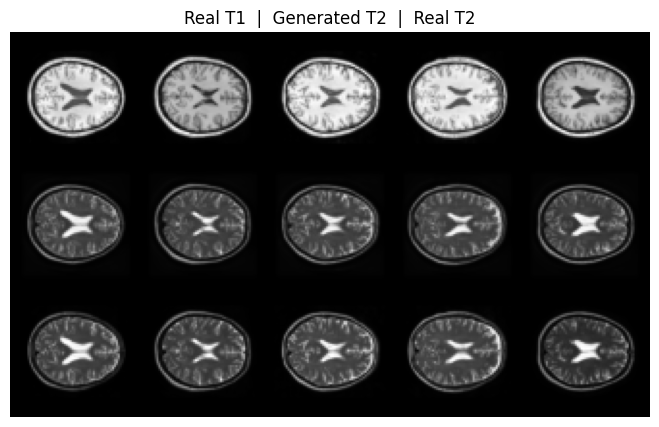

In [71]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def visualize_generated_images(generator, test_loader, device="cuda"):
    """Visualize a few generated T2-weighted images from the trained cGAN generator."""
    generator.eval()  # Set generator to evaluation mode
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    # Get a batch of test images
    batch = next(iter(test_loader))
    real_t1 = batch["T1"].type(Tensor).to(device)
    real_t2 = batch["T2"].type(Tensor).to(device)

    # Generate fake T2 images
    with torch.no_grad():
        fake_t2 = generator(real_t1)

    # Convert images to CPU for visualization
    real_t1 = real_t1.cpu()
    real_t2 = real_t2.cpu()
    fake_t2 = fake_t2.cpu()

    # Create a grid of images for visualization
    img_grid = make_grid(torch.cat((real_t1, fake_t2, real_t2), dim=0), nrow=5, normalize=True)

    # Display images
    plt.figure(figsize=(10, 5))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert CHW to HWC format
    plt.axis("off")
    plt.title("Real T1  |  Generated T2  |  Real T2")
    plt.show()

# Call the function to visualize
visualize_generated_images(generator_cgan, test_loader)


We will now evaluate the generator of the cGAN with the same three metrics
on both the training set and the test set by computing the mean value for
each metric:

In [72]:
evaluate_generator(generator_cgan)

<ipython-input-29-f4002985bd60>:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -10 * np.log10(mse)


,Training set,Test set
MAE,0.038623,0.042463
PSNR,22.971394,22.287226
SSIM,0.983322,0.979912


The performance is slightly lower for the cGAN, which is a bit disappointing.
This may be explained by the ease of the task and increase the complexity of
the architecture does not help. Another possibility would be to increase the
number of epochs, which we did not change in comparison to the architecture
with the generator alone.

Let's now try a more general approach that does not require paired samples.

# 3. CycleGAN

A cycle generative adversarial network (CycleGAN) is a technique for training
**unsupervised image translation** models via the GAN architecture using
unpaired collections of images from two different domains.
The main innovation of a CycleGAN is to introduce a
**cycle consistency loss** to enforce good reconstruction in both domains.

A CycleGAN consists of two GAN:

* one generating samples from domain *A* to domain *B*, and

* another one generating from domain *B* to domain *A*.

The cycle consistency consists in generating from one domain to the other
domain then generating back from the second domain to the first domain, and
comparing the generated sample from the original sample.
The image below (taken from the [original paper introducing CycleGAN](https://arxiv.org/pdf/1703.10593.pdf))
summarizes the main concepts of a CycleGAN:

<a href="https://ibb.co/WtS49wR">
   <img src="https://i.ibb.co/2NX12Qp/cyclegan.png" width="800" border="0">
</a>

## 3.1 Architecture of the CycleGAN

The discriminators of the CycleGAN do not have the true sample as input.
Thus, we have to remove the true sample in the `forward` method.

Otherwise, we will use the same architectures for the generators and for
the discriminators as the ones from the conditional GAN.

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import time

# Generator block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels=1, num_residual_blocks=6):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsampling = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Sequential(
            nn.Conv2d(64, in_channels, 7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsampling(x)
        x = self.residual_blocks(x)
        x = self.upsampling(x)
        return self.final(x)

# Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_cyclegan(train_loader, num_epochs=200, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator_A2B = Generator().to(device)
    generator_B2A = Generator().to(device)
    discriminator_A = Discriminator().to(device)
    discriminator_B = Discriminator().to(device)

    criterion_GAN = nn.MSELoss().to(device)
    criterion_cycle = nn.L1Loss().to(device)

    optimizer_G = optim.Adam(
        list(generator_A2B.parameters()) + list(generator_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, batch in enumerate(train_loader):
            real_A = batch["T1"].to(device).float()
            real_B = batch["T2"].to(device).float()

            valid = torch.ones((real_A.size(0), 1, 6, 6), device=device, dtype=torch.float32)
            fake = torch.zeros((real_A.size(0), 1, 6, 6), device=device, dtype=torch.float32)

            optimizer_G.zero_grad()
            fake_B = generator_A2B(real_A)
            fake_A = generator_B2A(real_B)
            loss_GAN_A2B = criterion_GAN(discriminator_B(fake_B), valid)
            loss_GAN_B2A = criterion_GAN(discriminator_A(fake_A), valid)

            loss_cycle_A = criterion_cycle(generator_B2A(fake_B), real_A)
            loss_cycle_B = criterion_cycle(generator_A2B(fake_A), real_B)
            loss_G = loss_GAN_A2B + loss_GAN_B2A + 10 * (loss_cycle_A + loss_cycle_B)
            loss_G.backward()
            optimizer_G.step()

            optimizer_D_A.zero_grad()
            loss_D_A = criterion_GAN(discriminator_A(real_A), valid) + criterion_GAN(discriminator_A(fake_A.detach()), fake)
            loss_D_A.backward()
            optimizer_D_A.step()

            optimizer_D_B.zero_grad()
            loss_D_B = criterion_GAN(discriminator_B(real_B), valid) + criterion_GAN(discriminator_B(fake_B.detach()), fake)
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss G: {loss_G.item():.4f}, Loss D_A: {loss_D_A.item():.4f}, Loss D_B: {loss_D_B.item():.4f}")

    return generator_A2B, generator_B2A

# Call the training function
generator_A2B, generator_B2A = train_cyclegan(train_loader, num_epochs=100, lr=0.0002)


Epoch [0/100], Step [0/12], Loss G: 15.4356, Loss D_A: 0.8065, Loss D_B: 1.5747
Epoch [1/100], Step [0/12], Loss G: 5.7460, Loss D_A: 2.0158, Loss D_B: 0.5308
Epoch [2/100], Step [0/12], Loss G: 3.1690, Loss D_A: 0.3635, Loss D_B: 0.4025
Epoch [3/100], Step [0/12], Loss G: 2.6346, Loss D_A: 0.5736, Loss D_B: 0.5897
Epoch [4/100], Step [0/12], Loss G: 2.4001, Loss D_A: 0.5458, Loss D_B: 0.5869
Epoch [5/100], Step [0/12], Loss G: 2.5185, Loss D_A: 0.5364, Loss D_B: 0.5459
Epoch [6/100], Step [0/12], Loss G: 2.5371, Loss D_A: 0.7466, Loss D_B: 0.4752
Epoch [7/100], Step [0/12], Loss G: 2.2393, Loss D_A: 0.4822, Loss D_B: 0.5269
Epoch [8/100], Step [0/12], Loss G: 2.4106, Loss D_A: 0.4379, Loss D_B: 0.5263
Epoch [9/100], Step [0/12], Loss G: 2.1532, Loss D_A: 0.5007, Loss D_B: 0.5012
Epoch [10/100], Step [0/12], Loss G: 2.0394, Loss D_A: 0.4720, Loss D_B: 0.5301
Epoch [11/100], Step [0/12], Loss G: 1.9394, Loss D_A: 0.6603, Loss D_B: 0.5208
Epoch [12/100], Step [0/12], Loss G: 1.8707, Loss

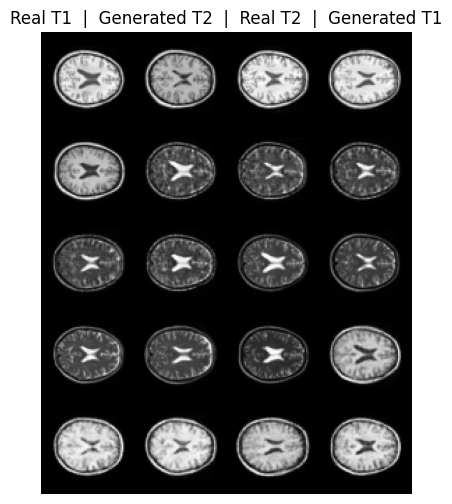

In [88]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def visualize_cyclegan_images(generator_A2B, generator_B2A, test_loader, device="cuda"):
    """Visualize a few generated images from the trained CycleGAN model."""
    generator_A2B.eval()  # Set generator to evaluation mode
    generator_B2A.eval()
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    # Get a batch of test images
    batch = next(iter(test_loader))
    real_A = batch["T1"].type(Tensor).to(device)  # Real T1 image
    real_B = batch["T2"].type(Tensor).to(device)  # Real T2 image

    # Generate images
    with torch.no_grad():
        fake_B = generator_A2B(real_A)  # T1 to T2
        fake_A = generator_B2A(real_B)  # T2 to T1

    # Convert images to CPU for visualization
    real_A = real_A.cpu()
    real_B = real_B.cpu()
    fake_A = fake_A.cpu()
    fake_B = fake_B.cpu()

    # Create a grid of images for visualization
    img_grid = make_grid(torch.cat((real_A, fake_B, real_B, fake_A), dim=0), nrow=4, normalize=True)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert CHW to HWC format
    plt.axis("off")
    plt.title("Real T1  |  Generated T2  |  Real T2  |  Generated T1")
    plt.show()

# Call the function to visualize images from CycleGAN
visualize_cyclegan_images(generator_A2B, generator_B2A, test_loader)

In [89]:
import torch
import torch.nn.functional as F
import numpy as np
from skimage.metrics import structural_similarity as ssim
from torchvision.transforms.functional import to_pil_image

def calculate_psnr(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse = F.mse_loss(img1, img2).item()
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_mae(img1, img2):
    """Calculate Mean Absolute Error (MAE) between two images."""
    return F.l1_loss(img1, img2).item()

def calculate_ssim(img1, img2):
    """Calculate Structural Similarity Index Measure (SSIM) between two images."""
    img1 = to_pil_image(img1)
    img2 = to_pil_image(img2)
    img1_np = np.array(img1.convert("L"))  # Convert to grayscale
    img2_np = np.array(img2.convert("L"))
    return ssim(img1_np, img2_np, data_range=img2_np.max() - img2_np.min())

def evaluate_cyclegan(generator, test_loader, device="cuda"):
    """Evaluate CycleGAN generator using PSNR, MAE, and SSIM metrics."""
    generator.eval()
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    psnr_values, mae_values, ssim_values = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            real_t1 = batch["T1"].type(Tensor).to(device)
            real_t2 = batch["T2"].type(Tensor).to(device)
            fake_t2 = generator(real_t1)

            for i in range(real_t1.size(0)):
                psnr_values.append(calculate_psnr(fake_t2[i], real_t2[i]))
                mae_values.append(calculate_mae(fake_t2[i], real_t2[i]))
                ssim_values.append(calculate_ssim(fake_t2[i].cpu(), real_t2[i].cpu()))

    print(f"Average PSNR: {np.mean(psnr_values):.4f} dB")
    print(f"Average MAE: {np.mean(mae_values):.4f}")
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")

# Call the function to evaluate CycleGAN
evaluate_cyclegan(generator_A2B, test_loader)

Average PSNR: 17.3468 dB
Average MAE: 0.0685
Average SSIM: 0.6385
